In [1]:
import os
import numpy as np
import pandas as pd
from statsmodels.api import OLS,Logit
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import argparse
from scipy.stats import zscore,pearsonr,spearmanr
from scipy.spatial.distance import euclidean
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from PRS import PRS # custom script to run PRS with DeGAs input data

/home/users/magu/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# 1. load data
dataset='/oak/stanford/groups/mrivas/projects/degas-risk/datasets/train/tsvd/all_z_center_p001_20190805_500PCs.npz'
npc=300
phe_codes=['HC382']
covariates=['age','sex']+['PC'+str(i+1) for i in range(4)]+['1']
score_pcs=['SCORE{}_SUM'.format(pc+1) for pc in range(npc)]
profl_pcs=['PROF_PC{}'.format(pc+1) for pc in range(npc)]
z=np.load(dataset)
scores=pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/scorefiles/'+
                      os.path.splitext(os.path.basename(dataset))[0]+'.sscore',
                     index_col='#IID')
phenos=pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/master_phe/master.phe',
                     usecols=['IID']+phe_codes+covariates[:-1],
                     index_col='IID',
                     na_values=-9)
phenos['1']=1
with open('/oak/stanford/groups/mrivas/users/magu/repos/rivas-lab/ukbb-tools/05_gbe/icdinfo.txt','r') as f:
    code_to_name = {line.split()[0]:line.split()[2].replace('_',' ').split('(')[0].capitalize() for line in f}

In [3]:
# 2. define population groupings
train=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                         'ukb24983_white_british_train.phe').iloc[:,0].astype(float).tolist())
valid=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                         'ukb24983_white_british_valid.phe').iloc[:,0].astype(float).tolist())
test=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                         'ukb24983_white_british_test.phe').iloc[:,0].astype(float).tolist())
nbw=set(pd.read_table('/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification/'+
                         'ukb24983_non_british_white.phe').iloc[:,0].astype(float).tolist())
print(list(map(len,[train,valid,test,nbw])))

[236004, 33715, 67429, 24908]


In [4]:
# 3. analysis
for phe_code in phe_codes:
    # run PRS for this trait if not already done
    prs_f=os.path.join('/oak/stanford/groups/mrivas/projects/degas-risk/PRS/train/',
                       os.path.splitext(os.path.basename(dataset))[0][:-7], 
                       phe_code+'_PRS.profile')
    if not os.path.exists(prs_f):
        PRS(dataset.replace('tsvd/','').replace('_500PCs.npz','.full_df.pkl.gz'), phe_code)
    prs=pd.read_table(prs_f, sep='\s+', usecols=['IID','SCORESUM'], index_col='IID')
    # name phenotype, set up datasets
    phe_name=code_to_name[phe_code]
    df=phenos.loc[train | valid | test | nbw, [phe_code]+covariates].dropna()
    df=df.merge(scores, left_index=True, right_index=True).merge(prs, left_index=True, right_index=True)
    weights=z['V'][np.where(z['label_phe_code'] == phe_code),:].flatten()[:npc]
    df['SCORE']=df[score_pcs].dot(weights)
    df.sort_values(by='SCORE', inplace=True, ascending=True)
    # is trait binary or quantitative?
    is_bin=(len(df[phe_code].value_counts()) == 2)
    if is_bin: 
        df[phe_code]-=1
        regress=Logit
    else:
        regress=OLS
    # setup for regression models
    models={m:{} for m in ['dPRS','COVAR','RESID','JOINT']}
    params={'dPRS':['SCORE'], 'COVAR':covariates, 'JOINT':covariates+['SCORE']}
    stats =pd.DataFrame(index=['train','valid','test','nbw'], columns=['n','beta2','auc','pearsonr','spearmanr'])
    # iterate through populations, fit/predict
    for pop_id,pop in zip(['train','valid','test','nbw'],[train,valid,test,nbw]):
        # take a new subset
        df2=df.loc[pop,:].dropna()
        pop=[ind for ind in pop if ind in df2.index]
        # zscore dPRS within the phenotype group; trait too if quantitative
        df2['SCORE']=zscore(df2['SCORE'])
        if not is_bin:
            df2[phe_code]=zscore(df2[phe_code])
        # loop over models: dPRS alone, covars alone, dPRS ~ resid(phe ~ covars), joint model
        for m in ['dPRS','COVAR','RESID','JOINT']:
            print(pop_id,m)
            # use covariate model fit within population, regress on residuals
            if m=='RESID':
                models[m][pop_id]=OLS(models['COVAR'][pop_id].resid_pearson, df2.loc[pop,'SCORE']).fit(disp=0)
            # use joint model fit in validation for test and nbw; fit in train for test
            elif m=='JOINT' and pop_id in ['test','nbw']:
                models[m][pop_id]=models[m]['valid']
            elif m=='JOINT' and pop_id == 'valid':
                models[m][pop_id]=models[m]['train']
            # otherwise just fit and assess within the same group
            else:
                models[m][pop_id]=regress(df2.loc[pop,phe_code], df2.loc[pop,params[m]]).fit(disp=0)
        # re-sort based on adjusted dPRS
        df2['dPRS']=models['JOINT'][pop_id].predict(df2[params['JOINT']])
        df2=df2.sort_values('dPRS').drop('dPRS', axis=1)
        # compute these stats: 
        # beta/OR of top 2% versus entire group; AUC of joint model (bin); r of resid model (qt); N
        if is_bin:
            stats.loc[pop_id,'beta2']=np.log(df2[phe_code].iloc[-int(0.02*len(pop)):].mean() / df2[phe_code].mean())
            stats.loc[pop_id,'auc']=roc_auc_score(df2.loc[pop,phe_code], 
                                                  models['JOINT'][pop_id].predict(df2.loc[pop,params['JOINT']]))
            stats.loc[pop_id,'pearsonr']='na'
            stats.loc[pop_id,'n']=df2.loc[pop,phe_code].value_counts().loc[1]
        else:
            stats.loc[pop_id,'beta2']=df2[phe_code].iloc[-int(0.02*len(pop)):].mean() - df2[phe_code].mean()
            stats.loc[pop_id,'auc']='na'
            stats.loc[pop_id,'pearsonr']=pearsonr(models['COVAR'][pop_id].resid, df2.loc[pop,'SCORE'])[0]
            stats.loc[pop_id,'n']=df2.loc[pop,phe_code].shape[0]
        # and spearman rho between dPRS and trait (bin & QT)
        stats.loc[pop_id,'spearmanr']=spearmanr(df2.loc[pop,phe_code],df2.loc[pop,'SCORE'])[0]
        # do clustering in test/nbw
        if pop_id == 'test' or pop_id == 'nbw':
            for pc in range(npc):
                df2[profl_pcs[pc]]=(df2[score_pcs[pc]] * weights[pc] * df['SCORE']).clip_lower(0)
            df2[profl_pcs] = normalize(df2[profl_pcs], norm='l1')
            centroid=df2[profl_pcs].median()
            df3=df2.iloc[-int(0.1*len(pop)):]
            df3['mahal']=df3[profl_pcs].apply(lambda x: euclidean(x, centroid), axis=1)
            m_star=df3['mahal'].mean() + 2*df3['mahal'].std()
            outliers=df3.query('mahal > @m_star').index
            # perform clustering
            k=1
            cluster = KMeans(n_clusters=k, n_init=25).fit(df3.loc[outliers,profl_pcs])
            pre_frac = 0.8 - 10.0/len(outliers)
            errors = [cluster.inertia_]
            for new_k in [2,3,4,5]:
                new_cluster = KMeans(n_clusters=new_k, n_init=25).fit(df3.loc[outliers,profl_pcs])
                errors.append(new_cluster.inertia_)
                if new_cluster.inertia_ / cluster.inertia_ < pre_frac**(new_k - k): 
                    cluster,k = new_cluster,new_k
    print(stats)

('train', 'dPRS')
('train', 'COVAR')
('train', 'RESID')
('train', 'JOINT')
('valid', 'dPRS')
('valid', 'COVAR')
('valid', 'RESID')
('valid', 'JOINT')
('test', 'dPRS')
('test', 'COVAR')
('test', 'RESID')
('test', 'JOINT')


/home/users/magu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('nbw', 'dPRS')
('nbw', 'COVAR')
('nbw', 'RESID')
('nbw', 'JOINT')
           n     beta2       auc pearsonr  spearmanr
train  30619  0.341919   0.54889       na  0.0441554
valid   4394  0.360755  0.546074       na  0.0430146
test    8606  0.294656  0.552421       na  0.0514373
nbw     3132  0.507308  0.530558       na  0.0396117


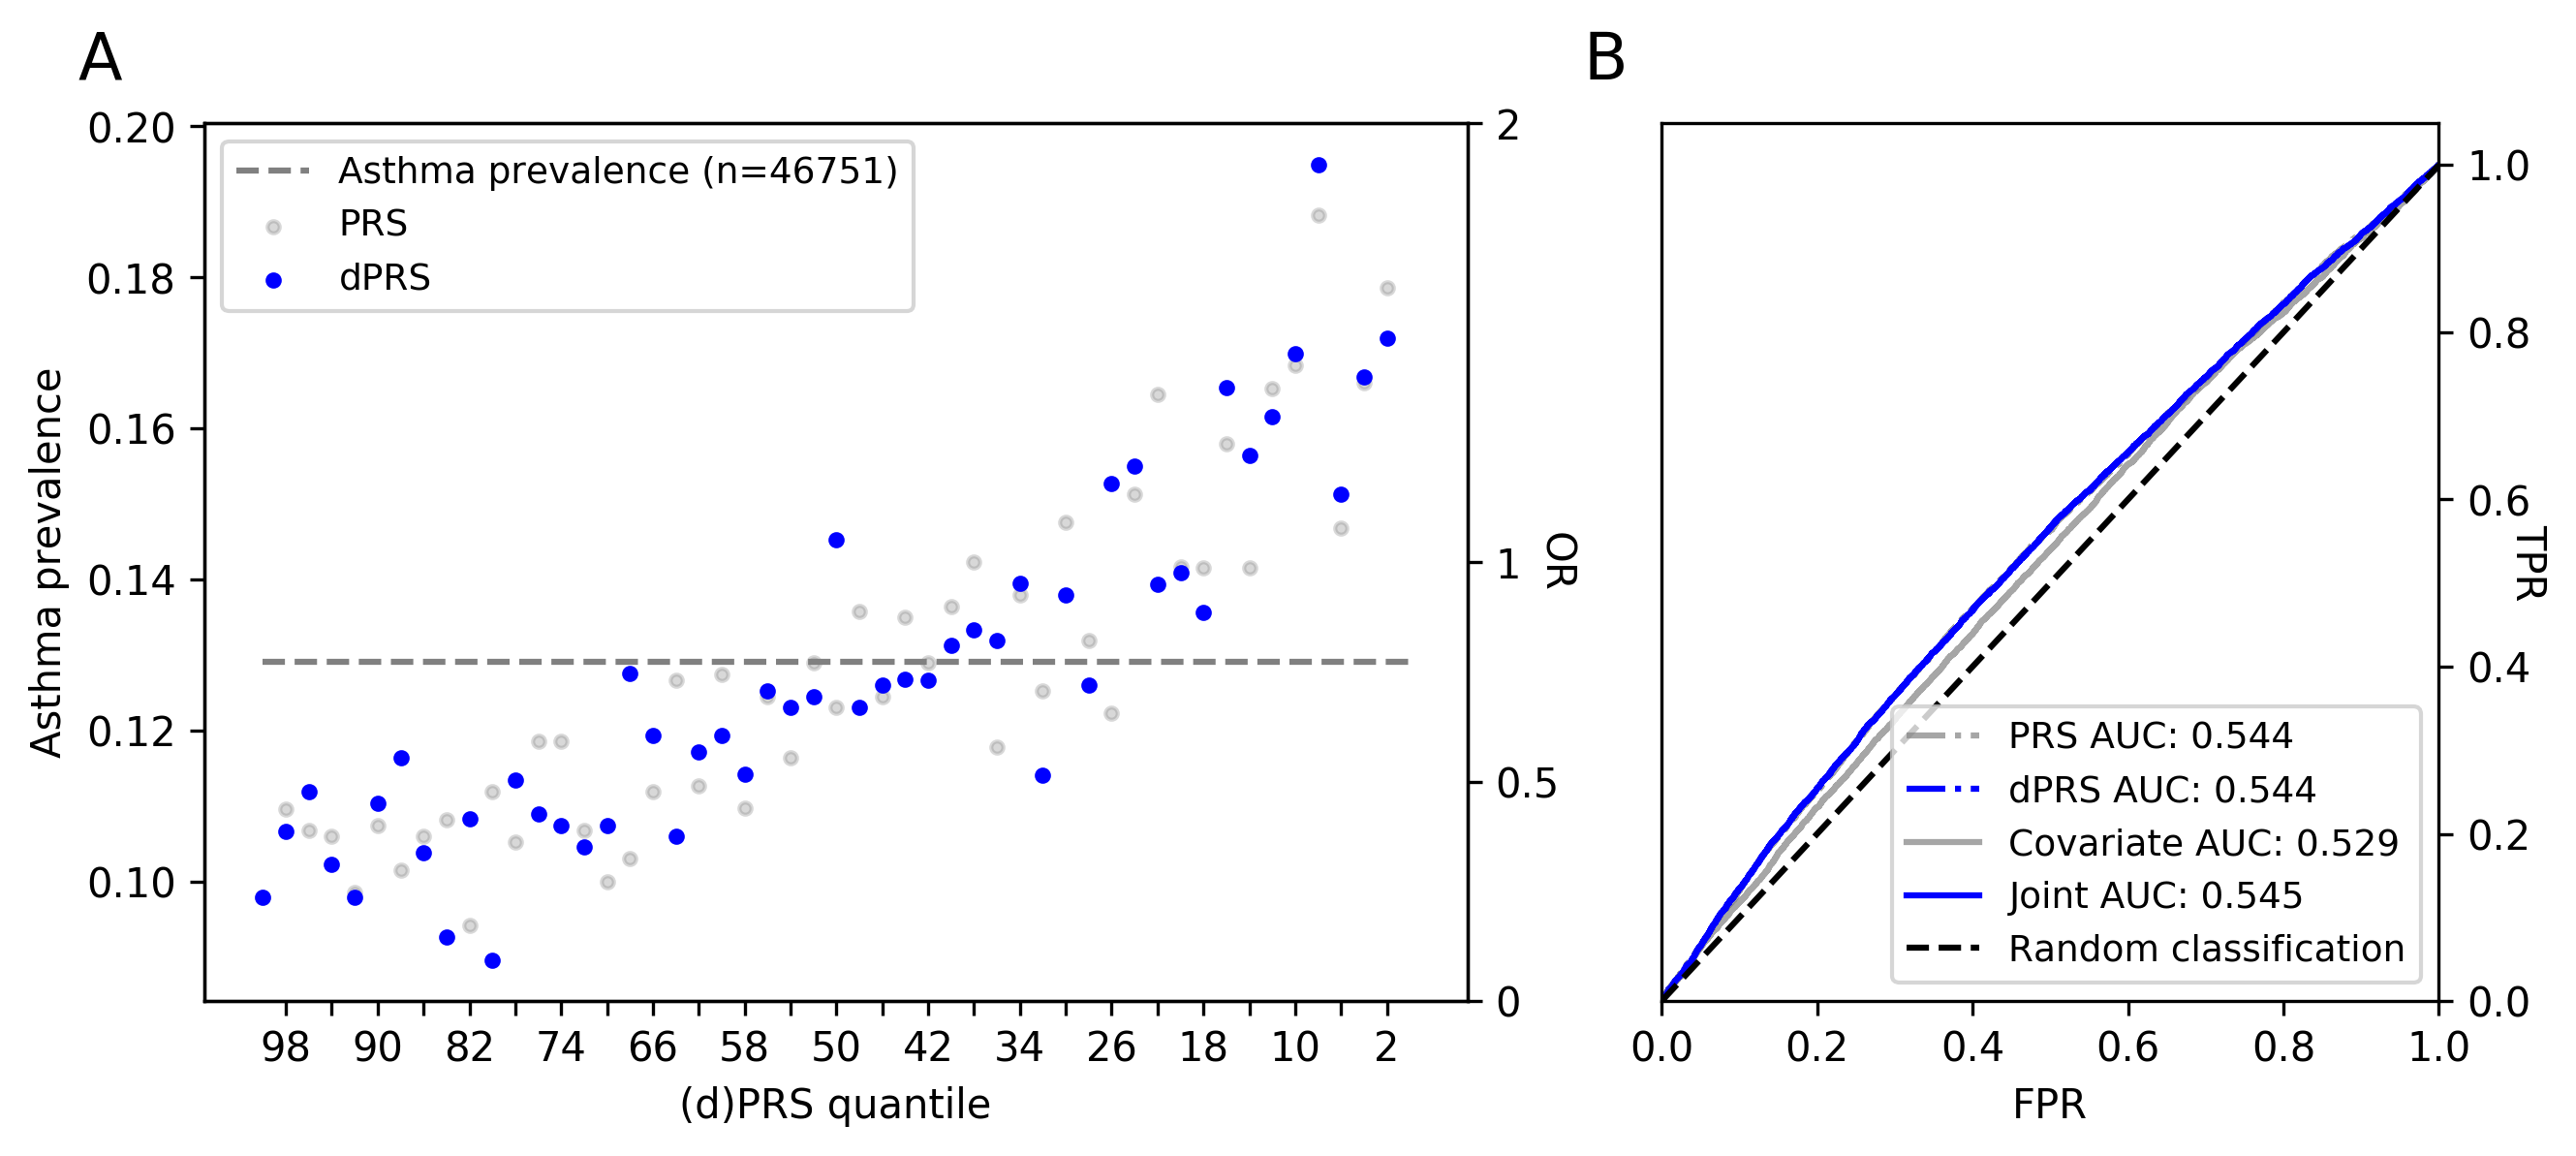

In [5]:
width = 2
# initialize plot objects
plots = [None for _ in range(width * len(phe_codes))]
plt.close('all'); plt.clf()
fig = plt.figure(figsize=(5*width + 1, 4*len(phe_codes)), dpi=300)
grid=gs.GridSpec(4*len(phe_codes), 5*width + 1, wspace=4, hspace=2)
        
for i,(pop_id,pop) in enumerate(zip(['test'], [test])):
    # setup plot
    for ix in range(width):
        plots[(width*i)+ix]=plt.subplot(grid[i*4:(i+1)*4, (6*ix):(6-(7*ix))])
    # redo joint models because we didn't do PRS above
    joint_model={}
    for prs in ['SCORE','SCORESUM']:
        joint_model[prs]=zscore(regress(df.loc[train,phe_code],
                                        df.loc[train,covariates+[prs]]
                                       ).fit(disp=0).predict(df.loc[pop,covariates+[prs]]))
    # make right half of plot
    if is_bin:
        # loop over dPRS and these joint models
        cov_prs=models['COVAR']['train'].predict(df.loc[pop,covariates])        
        for w,(name,prs) in enumerate(zip(['PRS','dPRS','Covariate','Joint'],
                                          [df.loc[pop,'SCORESUM'], 
                                           models['dPRS']['train'].predict(df.loc[pop, params['dPRS']]),
                                           models['COVAR']['train'].predict(df.loc[pop, params['COVAR']]),
                                           models['JOINT']['train'].predict(df.loc[pop, params['JOINT']])])):
            # compute stats, plot them
            fpr,tpr,_=roc_curve(df.loc[pop,phe_code],prs)
            roc_auc=roc_auc_score(df.loc[pop,phe_code],prs)
            plots[(2*i)+1].plot(fpr,tpr,label=name+' AUC: '+'{:.3f}'.format(roc_auc), 
                                color='b' if w%2 else 'grey', alpha=0.7+0.3*(w%2), linestyle='-' if w/2 else '-.')
        # add null line, axis labels
        plots[(2*i)+1].plot([0, 1],[0, 1],'k--',label='Random classification')
        plots[(2*i)+1].legend(fontsize=9)
        plots[(2*i)+1].set_xlim([0.0, 1.0])
        plots[(2*i)+1].set_ylim([0.0, 1.05])
        plots[(2*i)+1].set_ylabel('TPR', rotation=270)
        plots[(2*i)+1].set_xlabel('FPR')
    else:
        df.loc[pop,phe_code]=zscore(df.loc[pop,phe_code])
        # plot correlation with dPRS and residual phenotype
        for prs in ['SCORESUM','SCORE']: # scoresum is PRS, score is dPRS -- confused yet? me too.
            sns.regplot(x=df.loc[pop,prs], y=models['COVAR'][pop].fittedvalues, ax=plots[(2*i)+1],
                        scatter_kws={'s':2, 'alpha':0.3+0.7*(prs!='PRS')}, color='b' if prs!='PRS' else 'grey')
        plots[(2*i)+1].set_ylabel(code_to_name[phe_code]+' Residual', rotation=270)
        plots[(2*i)+1].legend([prs.replace('SCORESUM','PRS').replace('SCORE','dPRS')+' '+
                               '$r=$'+'{:.3f}'.format(pearsonr(dprs,df[prs])[0]) for prs in ['PRS','SCORE']])
    # now do quantile plot with modified (only if binary) phenotype
    n,nq=len(pop),50
    for prs,name in zip(['SCORESUM','SCORE'],['PRS','dPRS']):
        df2=df.loc[pop,:]
        df2['joint']=joint_model[prs]
        df2.sort_values('joint', ascending=True, inplace=True)
        plots[2*i].scatter(np.arange(nq), 
                           [df2.iloc[int(q*n/nq):int((q+1)*n/nq),:][phe_code].mean() for q in range(nq)], 
                           s=9, c='b' if name=='dPRS' else 'grey', alpha=0.3+0.7*(name=='dPRS'))
    # labels
    plots[2*i].set_ylabel(phe_name+' {}'.format('prevalence' if is_bin else 'mean'))
    plots[2*i].set_xticks(np.arange(1,nq+1,2))
    plots[2*i].set_xticklabels([int(100*q/nq) if q%4==1 else '' for q in reversed(range(1,nq+1,2))])
    plots[2*i].plot([0,nq],[df[phe_code].mean(),df[phe_code].mean()],'--',color='grey')
    plots[2*i].legend(['{0} (n={1})'.format(code_to_name[phe_code]+' prevalence' if is_bin 
                                                else 'Mean '+code_to_name[phe_code],
                                            int(df[phe_code].sum()) if is_bin else df.shape[0])]+['PRS','dPRS'], 
                       loc=2, fontsize=9)
    plots[2*i].text(-0.1, 1.05, chr((i%len(phe_codes))+65), 
                    fontsize=16, transform=plots[2*i].transAxes)
    plots[(2*i)+1].text(-0.1, 1.05, chr((i%len(phe_codes))+65+len(phe_codes)), 
                        fontsize=16, transform=plots[(2*i)+1].transAxes)
    # adjust y-axis to display odds ratios as well as prevalence (only binary traits)
    if is_bin:
        m,b=(plots[2*i].get_ylim()[1]-plots[2*i].get_ylim()[0]),plots[2*i].get_ylim()[0]
        y_or=plots[2*i].twinx()
        y_or.set_yticks([(o*df[phe_code].mean()-b)/m for o in [0,0.5,1,2,3,4,5,6,7,8,9] 
                          if df.iloc[-(n/nq):,:][phe_code].mean() > (o-1)*df[phe_code].mean()])
        y_or.set_yticklabels(map(lambda s:str(s), 
                                 filter(lambda o: df.iloc[-(n/nq):][phe_code].mean() > (o-1)*df[phe_code].mean(), 
                                        [0,0.5,1,2,3,4,5,6,7,8,9]))) 
        y_or.set_ylabel('OR',rotation=270)   
    plots[(2*i)+1].yaxis.tick_right()
    plots[(2*i)+1].yaxis.set_label_position("right")
    # add x-axis labels at the very end
    if i==len(phe_codes)-1:
        plots[(2*i)].set_xlabel('(d)PRS quantile')
    else:
        plots[(2*i)].set_xlabel('')


plt.show()
# fig.savefig("pdfs/fig2.pdf", bbox_inches='tight')